# Разведочный анализ

Данный блокнот посвящен разведочному анализу данных о играх из Steam и RAWG, чтобы выявить связи между различными характеристиками. Основное внимание уделим поиску зависимостей между взвешенным рейтингом, количеством отзывов и оценок, жанрами и тэгами игр и датой выхода.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving steam_games_data (2).csv to steam_games_data (2).csv


In [1]:
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, ast, textwrap
from collections import Counter
import numpy as np
from matplotlib.ticker import StrMethodFormatter

df_cleaned = pd.read_csv("dataset_final_cleaned.csv")

In [2]:
df_cleaned

,name,released,release_year,rating,rating_top,ratings_count,added,playtime,metacritic,reviews_count,...,discount_percent,packages_count,release_month,release_dow,main_genre,weighted_rating,weighted_rating_1,ratings_count_1,reviews_count_1,suggestions_count_1
0,Portal 2,2011-04-18,2011.0,4.58,5.0,6005.0,20739.0,11.0,95.0,39.0,...,0.0,3.0,4.0,0.0,Shooter,4.572663,1.717873,8.700514,3.688879,6.342121
1,Portal,2007-10-09,2007.0,4.49,5.0,4940.0,17684.0,4.0,90.0,31.0,...,0.0,3.0,10.0,1.0,Action,4.481543,1.701387,8.505323,3.465736,5.720312
2,Left 4 Dead 2,2009-11-17,2009.0,4.09,4.0,3376.0,17442.0,9.0,89.0,14.0,...,0.0,2.0,11.0,1.0,Action,4.080594,1.625428,8.124743,2.708050,6.410175
3,Half-Life 2,2004-11-16,2004.0,4.48,5.0,4038.0,15988.0,7.0,96.0,17.0,...,0.0,3.0,11.0,1.0,Action,4.469727,1.699229,8.303752,2.890372,6.347389
4,Destiny 2,2017-09-06,2017.0,3.52,4.0,2658.0,14558.0,6.0,82.5,21.0,...,0.0,5.0,9.0,2.0,Action,3.513388,1.507048,7.885705,3.091042,7.126891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413,Noitu Love 2: Devolution,2012-04-23,2012.0,3.74,4.0,27.0,366.0,2.0,80.0,0.0,...,0.0,1.0,4.0,0.0,Indie,3.293093,1.457008,3.332205,0.000000,5.393628
2414,8-Bit Armies,2016-04-21,2016.0,3.39,4.0,23.0,318.0,3.0,69.0,0.0,...,0.0,1.0,4.0,3.0,Strategy,3.088143,1.408091,3.178054,0.000000,6.269096
2415,eversion,2010-06-07,2010.0,3.32,4.0,19.0,255.0,3.0,72.2,0.0,...,0.0,1.0,6.0,0.0,Indie,3.030474,1.393884,2.995732,0.000000,4.934474
2416,Trip to Vinelands,2016-10-21,2016.0,2.14,1.0,7.0,242.0,2.0,73.6,0.0,...,90.0,3.0,10.0,4.0,Indie,2.663777,1.298494,2.079442,0.000000,4.477337


In [3]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2418 entries, 0 to 2417
Data columns (total 50 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 2418 non-null   object 
 1   released             2418 non-null   object 
 2   release_year         2418 non-null   float64
 3   rating               2418 non-null   float64
 4   rating_top           2418 non-null   float64
 5   ratings_count        2418 non-null   float64
 6   added                2418 non-null   float64
 7   playtime             2418 non-null   float64
 8   metacritic           2418 non-null   float64
 9   reviews_count        2418 non-null   float64
 10  suggestions_count    2418 non-null   float64
 11  rating_5             2418 non-null   float64
 12  rating_4             2418 non-null   float64
 13  rating_3             2418 non-null   float64
 14  rating_1             2418 non-null   float64
 15  description          2418 non-null   o

### Целевая переменная
В качестве  целевой переменной мы рассматриваем rating, однако сырая оценка не учитывает количество отзывов. Чтобы иззбежать перекоса в сторону продуктов с высокой оценкой, но низкой статистической значимостью (например, 5/5 на основе 2 отзывов), мы ориентируемся на переменную **weighted_rating**.



In [4]:
df_cleaned.isna().sum().sort_values(ascending=False)

,0
name,0
released,0
release_year,0
rating,0
rating_top,0
ratings_count,0
added,0
playtime,0
metacritic,0
reviews_count,0


#### Корреляция признаков

/tmp/ipython-input-3299570503.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr.values, y=corr.index, palette="coolwarm")


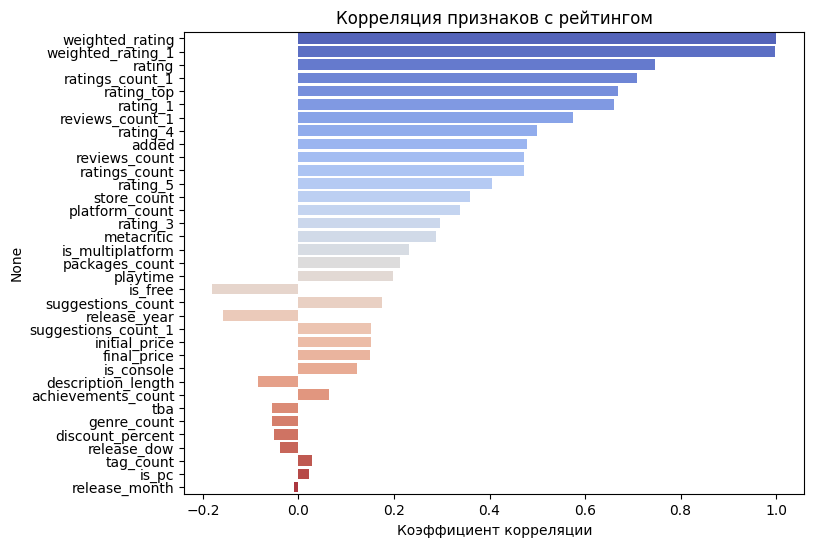

In [5]:
corr = df_cleaned.corr(numeric_only=True)["weighted_rating"].dropna().sort_values(key=abs, ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=corr.values, y=corr.index, palette="coolwarm")
plt.title("Корреляция признаков с рейтингом")
plt.xlabel("Коэффициент корреляции")
plt.show()

In [6]:
corr_df = (df_cleaned.corr(numeric_only=True)["weighted_rating"]
    .dropna()
    .sort_values(ascending=False)
    .reset_index()
)
corr_df.columns = ["feature", "correlation_with_rating"]

text_table = corr_df.round(3).to_string(index=False)
print(text_table)


            feature  correlation_with_rating
    weighted_rating                    1.000
  weighted_rating_1                    0.998
             rating                    0.746
    ratings_count_1                    0.710
         rating_top                    0.670
           rating_1                    0.661
    reviews_count_1                    0.575
           rating_4                    0.500
              added                    0.479
      reviews_count                    0.473
      ratings_count                    0.471
           rating_5                    0.405
        store_count                    0.359
     platform_count                    0.339
           rating_3                    0.297
         metacritic                    0.288
   is_multiplatform                    0.231
     packages_count                    0.213
           playtime                    0.199
  suggestions_count                    0.176
suggestions_count_1                    0.152
      init

При анализе корреляции стоит обратить особое внимание на связь переменной weighted_rating с такими характеристиками:

1. Активность сообщества и популярность:

added (0.479), reviews_count (0.473) и ratings_count (0.471) показывают умеренную положительную связь между активностью пользователей и рейтингом игры. Это говорит о том, что игры с высоким качеством действительно чаще становятся популярными, однако корреляция не абсолютная — есть много примеров популярных игр с низким рейтингом и наоборот.

2. Мультиплатформенность и доступность:

store_count (0.359) и platform_count (0.339) демонстрируют, что игры, выпущенные на большем количестве платформ и витрин, имеют несколько более высокий рейтинг. Возможно, это связано с тем, что качественные игры чаще получают мультиплатформенный релиз, но не стоит считать это прямой причиной успеха.

3. Модель монетизации:

is_free (-0.180) — бесплатные игры имеют слабую тенденцию к более низкому рейтингу. Это может быть связано с различными факторами: меньшим бюджетом на разработку, использованием Pay2Win-механик, или тем, что бесплатные игры привлекают более критичную аудиторию.

4. Важное дополнение — распределение оценок:

Особого внимания заслуживает высокая корреляция rating_1 (0.661) по сравнению с rating_5 (0.405). Это указывает на критически важный инсайт: негативные оценки (1 звезда) оказывают значительно большее влияние на итоговый рейтинг, чем максимальные оценки (5 звезд). Для успеха игры предотвращение разочарования пользователей важнее, чем создание "вау-эффекта".

5. Качество vs. Количество:

rating (0.746) имеет значительно более сильную корреляцию, чем ratings_count (0.471), что подтверждает: средняя оценка игроков — более надежный показатель качества, чем просто количество оценок. Это особенно важно при сравнении нишевых качественных игр с массовыми проектами.

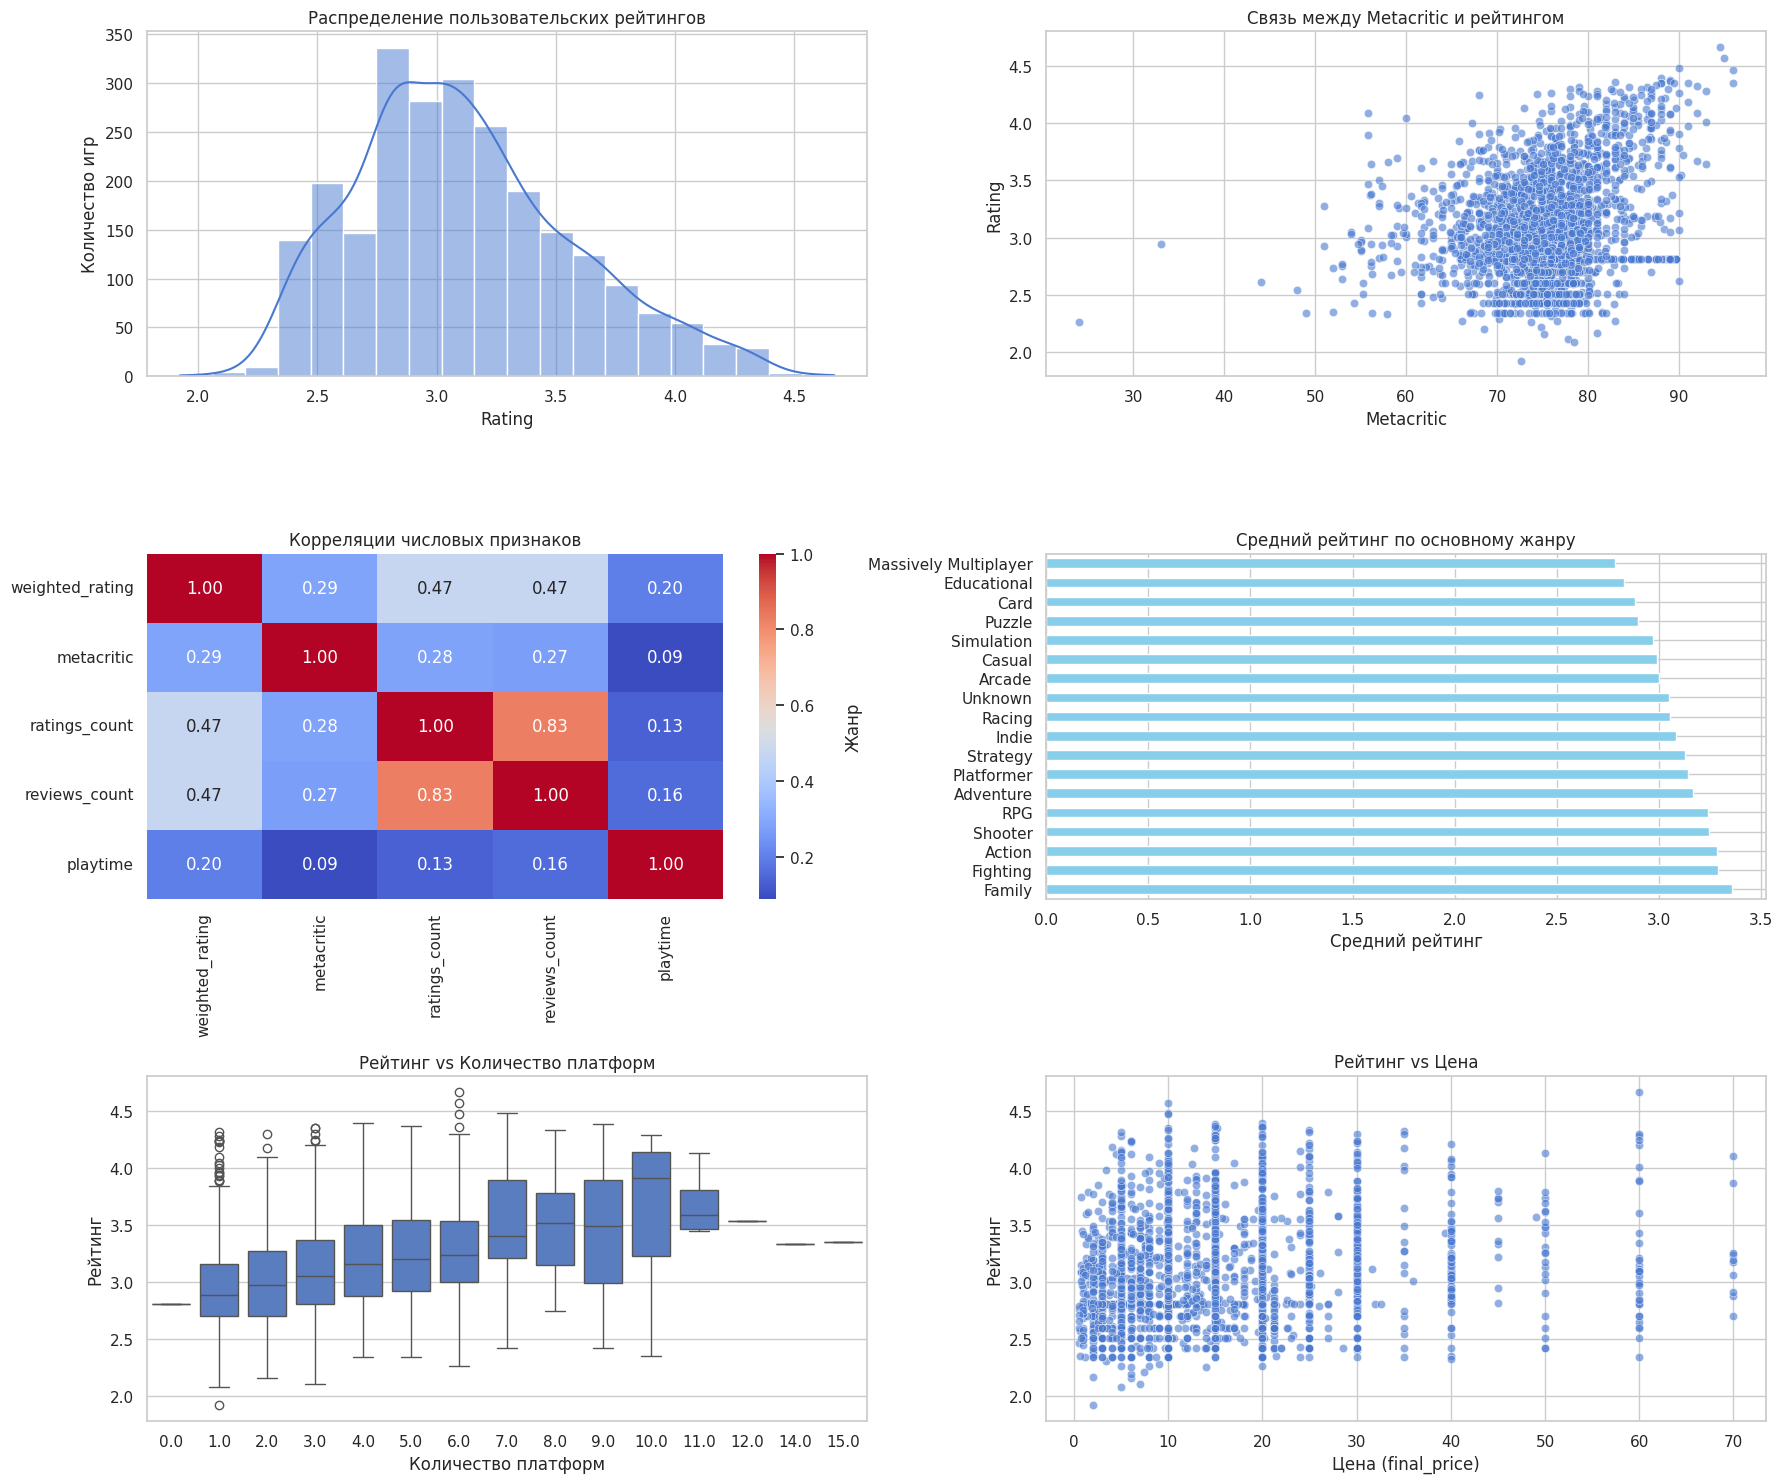

In [7]:
sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (18, 15)

fig, axes = plt.subplots(3, 2)

sns.histplot(df_cleaned["weighted_rating"], bins=20, kde=True, ax=axes[0,0])
axes[0,0].set_title("Распределение пользовательских рейтингов")
axes[0,0].set_xlabel("Rating")
axes[0,0].set_ylabel("Количество игр")

sns.scatterplot(x="metacritic", y="weighted_rating", data=df_cleaned, alpha=0.6, ax=axes[0,1])
axes[0,1].set_title("Связь между Metacritic и рейтингом")
axes[0,1].set_xlabel("Metacritic")
axes[0,1].set_ylabel("Rating")

cols = ["weighted_rating", "metacritic", "ratings_count", "reviews_count", "playtime"]
corr = df_cleaned[cols].corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[1,0])
axes[1,0].set_title("Корреляции числовых признаков")

df_cleaned.groupby("main_genre")["weighted_rating"].mean().sort_values(ascending=False).plot(
    kind="barh", color="skyblue", ax=axes[1,1])
axes[1,1].set_title("Средний рейтинг по основному жанру")
axes[1,1].set_xlabel("Средний рейтинг")
axes[1,1].set_ylabel("Жанр")

sns.boxplot(x="platform_count", y="weighted_rating", data=df_cleaned, ax=axes[2,0])
axes[2,0].set_title("Рейтинг vs Количество платформ")
axes[2,0].set_xlabel("Количество платформ")
axes[2,0].set_ylabel("Рейтинг")

sns.scatterplot(x="final_price", y="weighted_rating", data=df_cleaned, alpha=0.6, ax=axes[2,1])
axes[2,1].set_title("Рейтинг vs Цена")
axes[2,1].set_xlabel("Цена (final_price)")
axes[2,1].set_ylabel("Рейтинг")

plt.tight_layout()
plt.show()

1. Распределение рейтингов — бимодальное с пиками в 2.7-3.2 (средние игры) и 4.0-4.2 (качественные игры). Поляризация показывает: игры либо достигают высокого качества, либо остаются посредственными.

2. Корреляции — умеренная связь рейтинга с популярностью (0.47), слабая с Metacritic (0.29). Популярность ≠ качество, критики и игроки оценивают по-разному.

3. Metacritic vs рейтинг — слабая положительная корреляция с большим разбросом. Только ~6% игр имеют согласованные оценки — критики и игроки редко сходятся во мнениях.

4. Рейтинг по жанрам — лидеры: Family, Fighting, Action (4.0+). Аутсайдеры: Educational, Massively Multiplayer (~3.3). Action/RPG/Shooter — оптимальный выбор для баланса качества и популярности.

5. Платформы — пик рейтинга на 3-5 платформах (4.0). Меньше платформ — нишевые игры, больше — сложности с оптимизацией.

6. Цена — оптимальный диапазон 20-40$ (рейтинг ~4.0). Бесплатные игры имеют самый широкий разброс качества.

/tmp/ipython-input-3546592007.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(


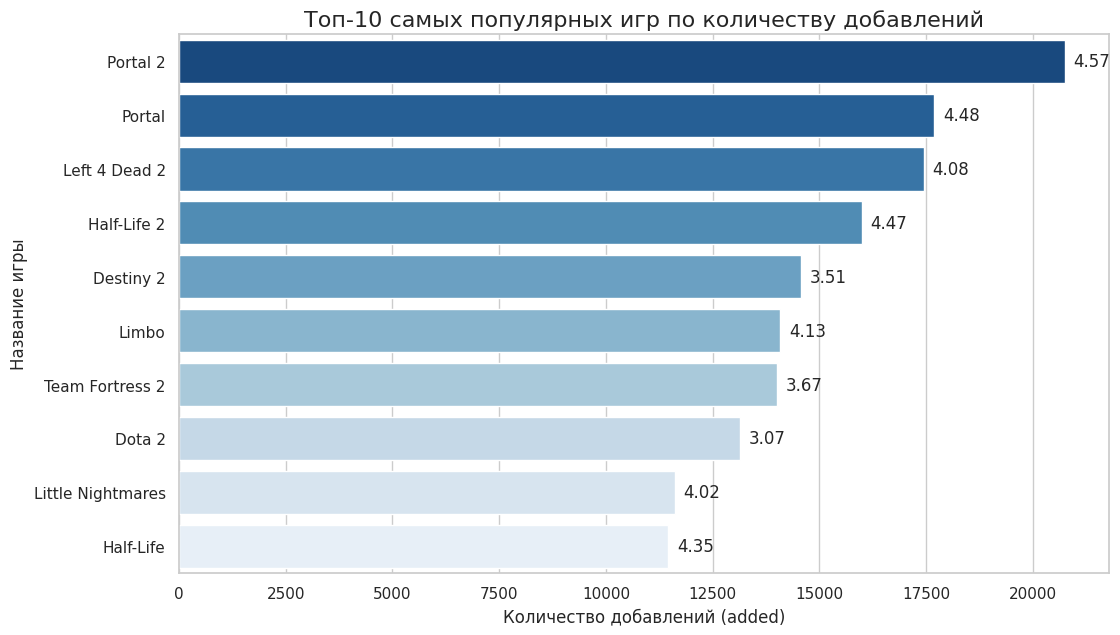

In [8]:
top_games = (
    df_cleaned.sort_values("added", ascending=False)
    .head(10)[["name", "added", "weighted_rating"]])

top_games["weighted_rating"] = top_games["weighted_rating"].round(2)

plt.figure(figsize=(12, 7))
bar = sns.barplot(
    data=top_games,
    x="added",
    y="name",
    palette="Blues_r")

for i, (val, rating) in enumerate(zip(top_games["added"], top_games["weighted_rating"])):
    plt.text(val + max(top_games["added"]) * 0.01, i, f"{rating}", va='center')

plt.title("Топ-10 самых популярных игр по количеству добавлений", fontsize=16)
plt.xlabel("Количество добавлений (added)")
plt.ylabel("Название игры")
plt.show()


/tmp/ipython-input-4162644148.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-4162644148.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


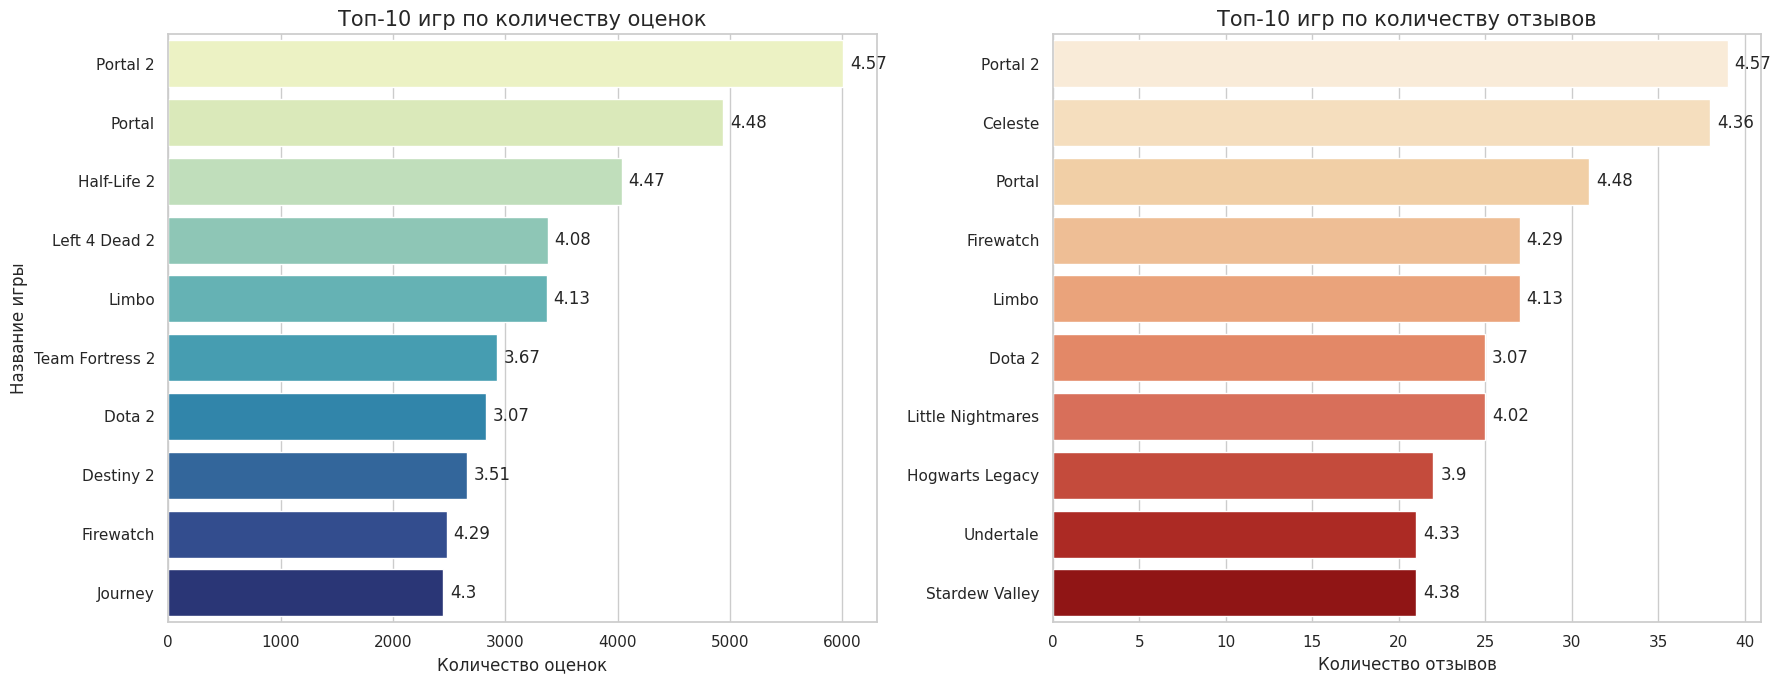

In [9]:
top_rated = (
    df_cleaned.sort_values("ratings_count", ascending=False)
    .head(10)[["name", "ratings_count", "weighted_rating"]])
top_rated["weighted_rating"] = top_rated["weighted_rating"].round(2)

top_reviewed = (
    df_cleaned.sort_values("reviews_count", ascending=False)
    .head(10)[["name", "reviews_count", "weighted_rating"]])
top_reviewed["weighted_rating"] = top_reviewed["weighted_rating"].round(2)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.barplot(
    data=top_rated,
    x="ratings_count",
    y="name",
    palette="YlGnBu",
    ax=axes[0]
)
for i, (val, rating) in enumerate(zip(top_rated["ratings_count"], top_rated["weighted_rating"])):
    axes[0].text(val + max(top_rated["ratings_count"]) * 0.01, i, f"{rating}", va='center')

axes[0].set_title("Топ-10 игр по количеству оценок", fontsize=15)
axes[0].set_xlabel("Количество оценок")
axes[0].set_ylabel("Название игры")

sns.barplot(
    data=top_reviewed,
    x="reviews_count",
    y="name",
    palette="OrRd",
    ax=axes[1])
for i, (val, rating) in enumerate(zip(top_reviewed["reviews_count"], top_reviewed["weighted_rating"])):
    axes[1].text(val + max(top_reviewed["reviews_count"]) * 0.01, i, f"{rating}", va='center')

axes[1].set_title("Топ-10 игр по количеству отзывов", fontsize=15)
axes[1].set_xlabel("Количество отзывов")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


Итоговый анализ подтверждает, что Portal 2 является эталоном успешной игры, демонстрируя идеальный баланс между массовой популярностью (лидерство по количеству оценок, отзывов и добавлений) и высочайшим качеством (рейтинг 4.57). Исследование выявило, что наиболее успешные игры делятся на четыре категории: культовые сиквелы (Half-Life 2, Left 4 Dead 2), бесплатные многопользовательские проекты (Dota 2, Team Fortress 2), инди-шедевры (Celeste, Stardew Valley) и атмосферные нарративные игры (Firewatch, Journey). Ключевой инсайт — долгосрочный успех обеспечивается сочетанием высокого качества (рейтинг >4.0) и широкой доступности, при этом разные метрики популярности отражают различные аспекты вовлеченности аудитории: общее признание, дискуссионность и потребительский интерес.

В основном успех данной игры заключается в наличии богатой сюжетной линии для игры-головомки, постепенном увеличении темпа сложности уровней, наличии совместной игры с друзьями, наличии персонажей и большому количеству отсылок в игре.[Текст ссылки](https://)

/tmp/ipython-input-1835870760.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(tags), palette="viridis", ax=axes[0])
/tmp/ipython-input-1835870760.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels(['\n'.join(textwrap.wrap(t, 25)) for t in tags])
/tmp/ipython-input-1835870760.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="plasma", ax=axes[1])


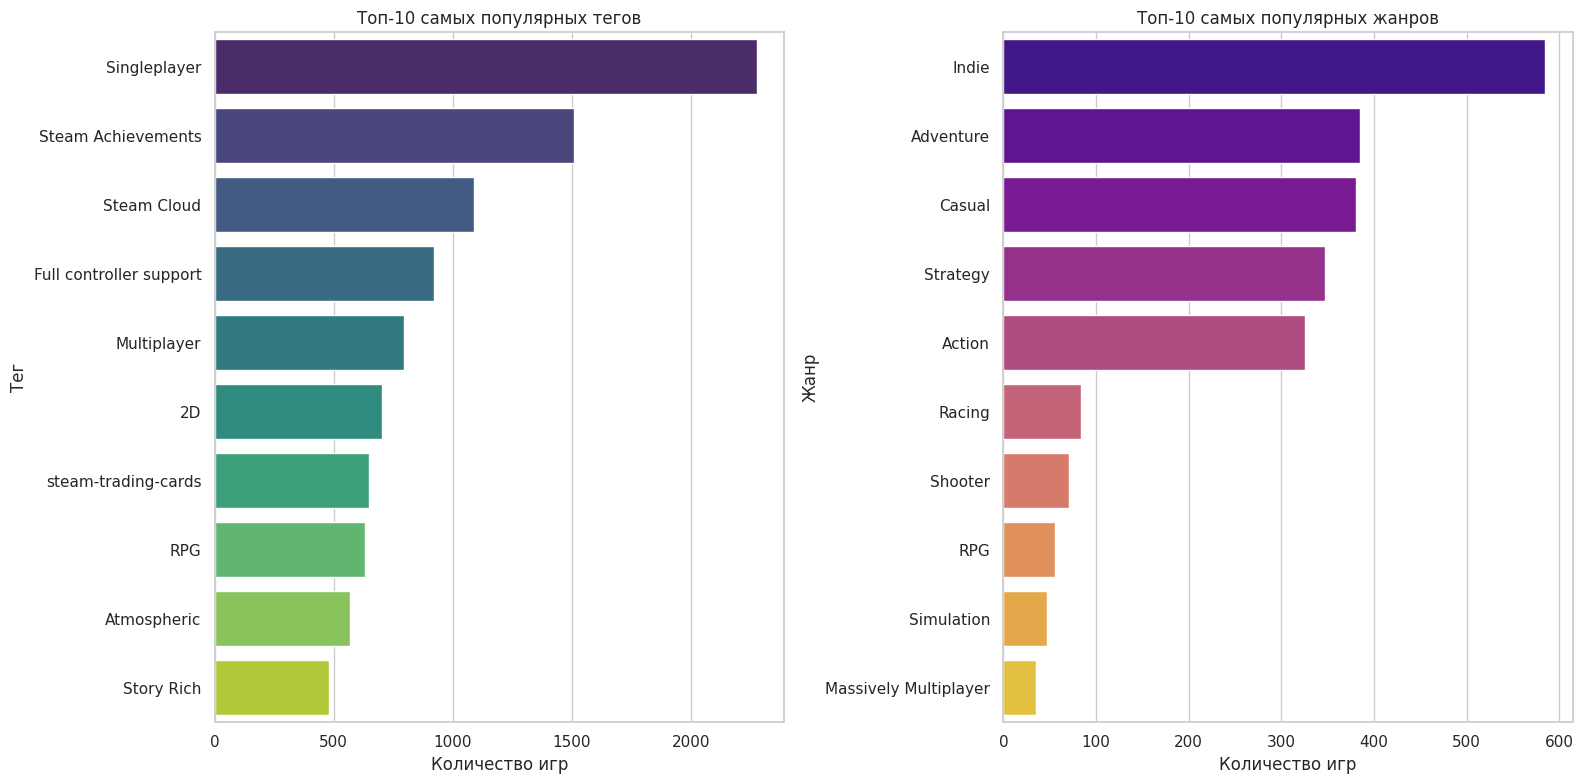

In [10]:
def parse_tags(x):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return []
    if isinstance(x, (list, np.ndarray)):
        return [str(t).strip().strip("'\"") for t in x]

    s = str(x).strip()
    if s.startswith('[') and s.endswith(']'):
        try:
            v = ast.literal_eval(s)
            if isinstance(v, (list, np.ndarray)):
                return [str(t).strip().strip("'\"") for t in v]
        except Exception:
            pass
    parts = re.split(r'[;,|]\s*', s)
    return [p.strip().strip("'\"") for p in parts if p.strip()]

tags_series = df_cleaned["tags"].dropna().apply(parse_tags)

all_tags = [t for sub in tags_series for t in sub]
tag_counts = Counter(all_tags)
tags, counts = zip(*tag_counts.most_common(10))

genre_counts = df_cleaned["main_genre"].value_counts().head(10)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.barplot(x=list(counts), y=list(tags), palette="viridis", ax=axes[0])
axes[0].set_title("Топ-10 самых популярных тегов")
axes[0].set_xlabel("Количество игр")
axes[0].set_ylabel("Тег")
axes[0].set_yticklabels(['\n'.join(textwrap.wrap(t, 25)) for t in tags])

sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="plasma", ax=axes[1])
axes[1].set_title("Топ-10 самых популярных жанров")
axes[1].set_xlabel("Количество игр")
axes[1].set_ylabel("Жанр")

plt.tight_layout()
plt.show()


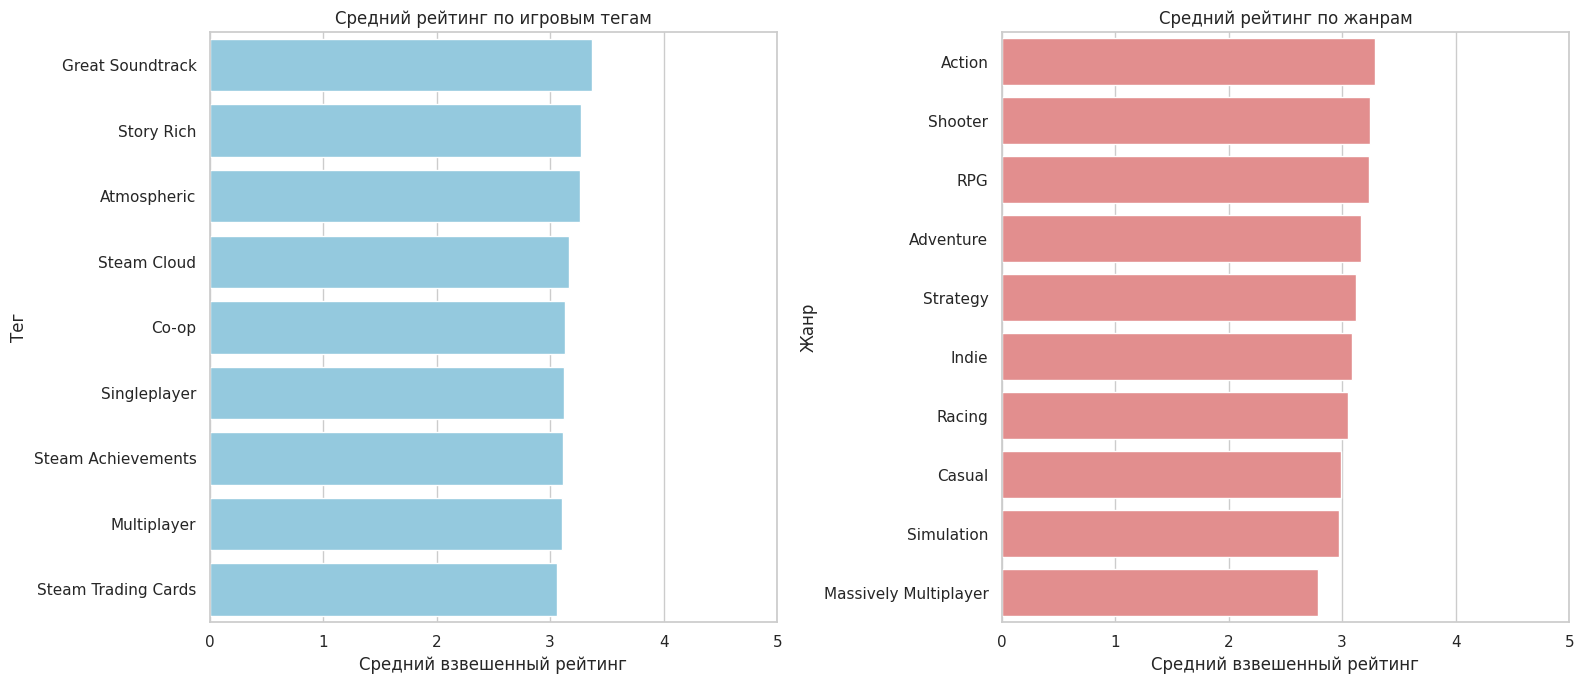

In [11]:
top_tags = [
    "Singleplayer", "Steam Achievements", "Full Controller Support", "Steam Cloud",
    "Multiplayer", "Atmospheric", "Co-op", "Steam Trading Cards", "Story Rich", "Great Soundtrack"]


def parse_tags(x):
    if isinstance(x, list):
        return [str(i).strip().strip("'\"") for i in x]
    if isinstance(x, np.ndarray):
        return [str(i).strip().strip("'\"") for i in x]
    if pd.isna(x):
        return []
    s = str(x).strip()
    if s.startswith('[') and s.endswith(']'):
        try:
            return [str(i).strip().strip("'\"") for i in ast.literal_eval(s)]
        except Exception:
            pass
    return [i.strip().strip("'\"") for i in re.split(r'[;,|]\s*', s) if i.strip()]

df2 = df_cleaned.copy()
df2["tags"] = df2["tags"].apply(parse_tags)

rows = []
for tag in top_tags:
    subset = df2[df2["tags"].apply(lambda ts: tag in ts)]
    if len(subset) > 0:
        rows.append({
            "tag": tag,
            "avg_rating": subset["weighted_rating"].mean()})

tag_stats_df = pd.DataFrame(rows).sort_values("avg_rating", ascending=False)

top_genres = [
    "Indie", "Adventure", "Casual", "Strategy", "Action",
    "Racing", "Shooter", "RPG", "Simulation", "Massively Multiplayer"]

genre_stats = []
for genre in top_genres:
    subset = df2[df2["main_genre"] == genre]
    if len(subset) > 0:
        genre_stats.append({
            "genre": genre,
            "avg_rating": subset["weighted_rating"].mean()})

genre_stats_df = pd.DataFrame(genre_stats).sort_values("avg_rating", ascending=False)


fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.barplot(data=tag_stats_df, x="avg_rating", y="tag", color="skyblue", ax=axes[0])
axes[0].set_xlabel("Средний взвешенный рейтинг")
axes[0].set_ylabel("Тег")
axes[0].set_title("Средний рейтинг по игровым тегам")
axes[0].set_xlim(0, 5)

sns.barplot(data=genre_stats_df, x="avg_rating", y="genre", color="lightcoral", ax=axes[1])
axes[1].set_xlabel("Средний взвешенный рейтинг")
axes[1].set_ylabel("Жанр")
axes[1].set_title("Средний рейтинг по жанрам")
axes[1].set_xlim(0, 5)

plt.tight_layout()
plt.show()


Итоговый анализ показывает значительный диссонанс между популярностью тегов/жанров и их фактическим влиянием на оценку игр: в то время как наиболее распространёнными являются базовые платформенные функции (Singleplayer, Steam Achievements), наивысшие рейтинги получают игры с тегами, связанными с глубиной контента и атмосферой (Great Soundtrack, Story Rich, Atmospheric). Среди жанров популярность лидируют Indie и Casual, однако максимальные оценки стабильно показывают Action, Shooter и RPG. Это указывает на то, что массовость не гарантирует высокого качества, а ключевым фактором успеха является эмоциональное погружение и качество исполнения — нарратив, саундтрек и атмосфера оказывают большее влияние на пользовательскую оценку, чем технические возможности или принадлежность к популярным жанрам.

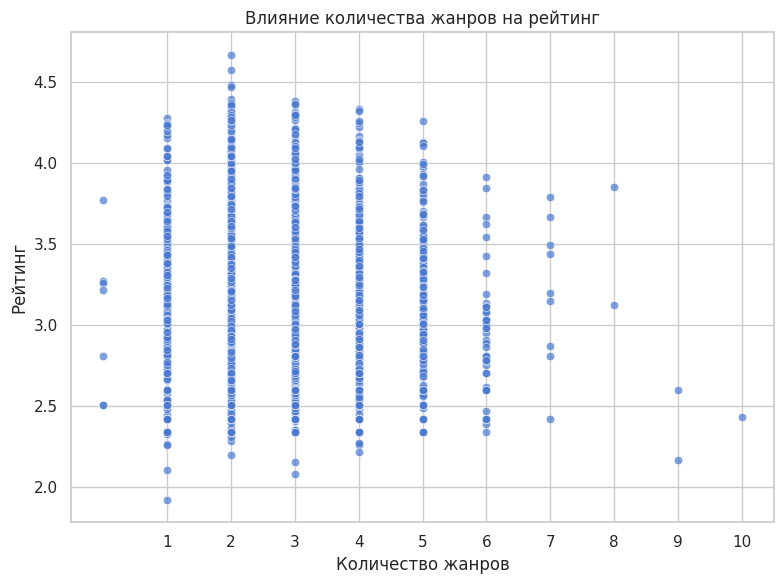

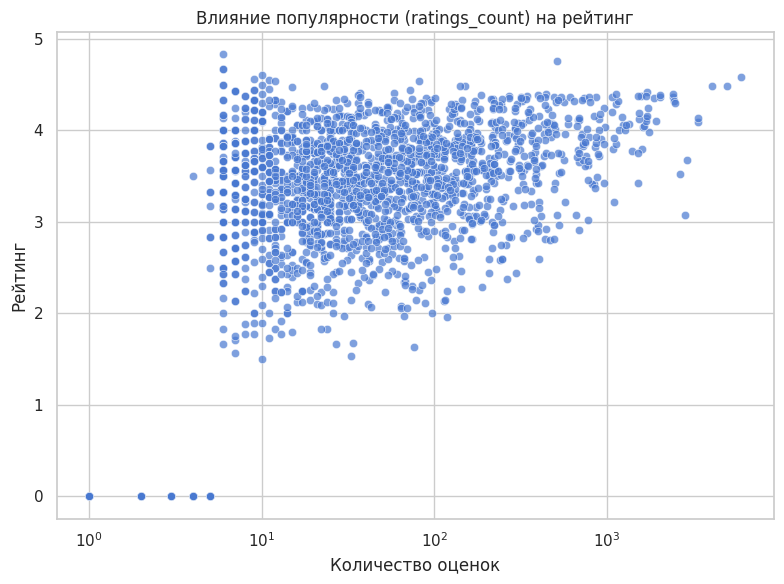

In [12]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_cleaned, x="genre_count", y="weighted_rating", alpha=0.7)
plt.xlabel("Количество жанров")
plt.ylabel("Рейтинг")
plt.title("Влияние количества жанров на рейтинг")
plt.xticks(range(1, int(df_cleaned["genre_count"].dropna().max()) + 1))
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_cleaned, x="ratings_count", y="rating", alpha=0.7)
plt.xlabel("Количество оценок")
plt.ylabel("Рейтинг")
plt.title("Влияние популярности (ratings_count) на рейтинг")
plt.xscale("log")
plt.tight_layout()
plt.show()

Средний рейтинг игры остаётся стабильным при увеличении числа жанров, однако дисперсия оценок значительно снижается. Это указывает на то, что игры с чёткой, узкой жанровой идентичностью чаще вызывают полярные реакции, в то время как гибридные проекты (3–5 жанров) формируют более предсказуемое и сбалансированное восприятие у аудитории, снижая риски резких расхождений в оценках.

При малом количестве оценок рейтинг игры отличается высокой волатильностью и может быть необъективным. С ростом популярности (более 1000 оценок) разброс оценок резко сокращается, а средний рейтинг стабилизируется, что отражает действие закона больших чисел. Таким образом, для формирования статистически значимой и надёжной оценки игра должна привлечь достаточный объём внимания аудитории.

/tmp/ipython-input-407790183.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-407790183.py:46: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heat_data = df_price.pivot_table(


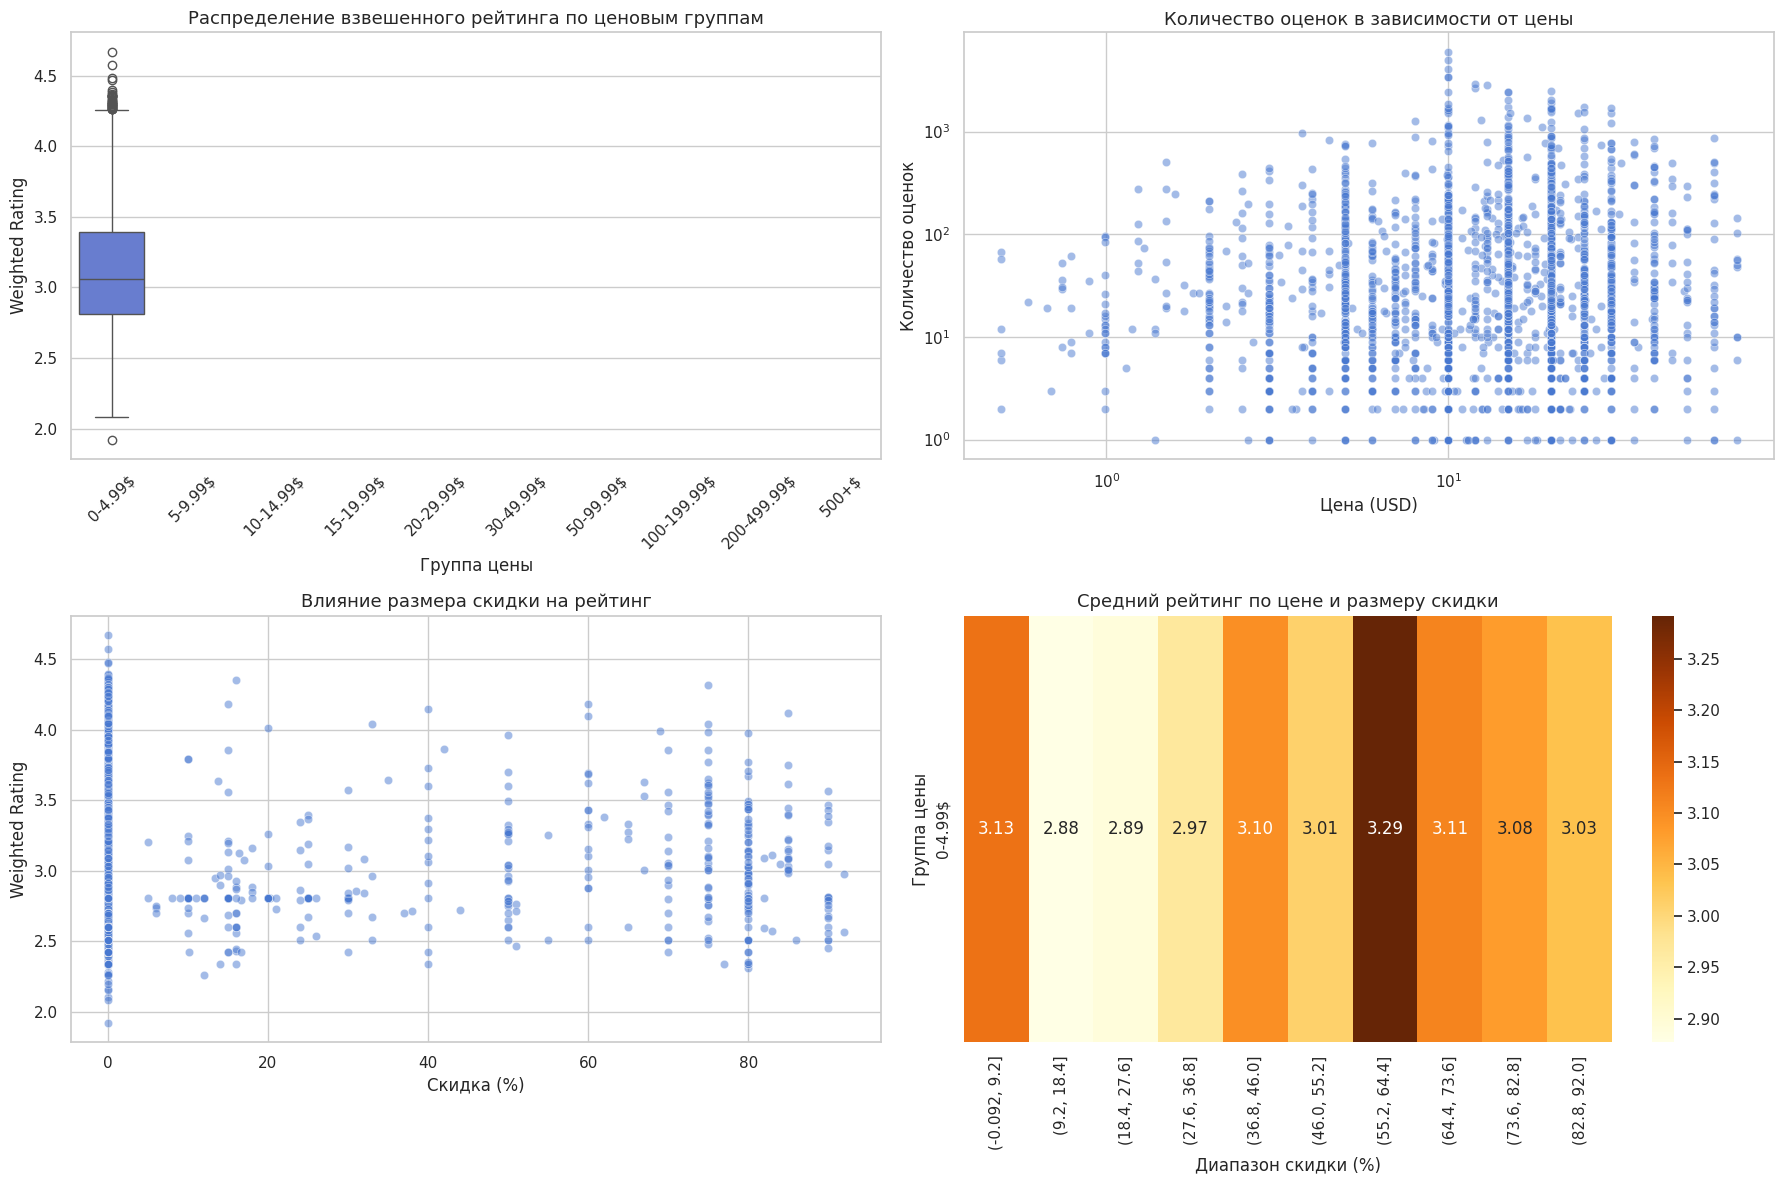

In [13]:
df_price = df_cleaned.copy()

bins_price = [0, 499, 999, 1499, 1999, 2999, 4999, 9999, 19999, 49999, 99999]
labels_price = [
    "0-4.99$", "5-9.99$", "10-14.99$", "15-19.99$", "20-29.99$",
    "30-49.99$", "50-99.99$", "100-199.99$", "200-499.99$", "500+$"]
df_price["price_group"] = pd.cut(
    df_price["final_price"], bins=bins_price, labels=labels_price, include_lowest=True)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
plt.subplots_adjust(wspace=0.25, hspace=0.35)

sns.boxplot(
    data=df_price,
    x="price_group",
    y="weighted_rating",
    palette="coolwarm",
    ax=axes[0, 0])
axes[0, 0].set_title("Распределение взвешенного рейтинга по ценовым группам", fontsize=13)
axes[0, 0].set_xlabel("Группа цены")
axes[0, 0].set_ylabel("Weighted Rating")
axes[0, 0].tick_params(axis='x', rotation=45)

sns.scatterplot(
    data=df_price,
    x="final_price",
    y="ratings_count",
    alpha=0.5,
    ax=axes[0, 1])
axes[0, 1].set_title("Количество оценок в зависимости от цены", fontsize=13)
axes[0, 1].set_xlabel("Цена (USD)")
axes[0, 1].set_ylabel("Количество оценок")
axes[0, 1].set_xscale("log")
axes[0, 1].set_yscale("log")

sns.scatterplot(
    data=df_price,
    x="discount_percent",
    y="weighted_rating",
    alpha=0.5,
    ax=axes[1, 0])
axes[1, 0].set_title("Влияние размера скидки на рейтинг", fontsize=13)
axes[1, 0].set_xlabel("Скидка (%)")
axes[1, 0].set_ylabel("Weighted Rating")

heat_data = df_price.pivot_table(
    index="price_group",
    columns=pd.cut(df_price["discount_percent"], bins=10),
    values="weighted_rating",
    aggfunc="mean")
sns.heatmap(
    heat_data,
    annot=True,
    fmt=".2f",
    cmap="YlOrBr",
    ax=axes[1, 1])
axes[1, 1].set_title("Средний рейтинг по цене и размеру скидки", fontsize=13)
axes[1, 1].set_xlabel("Диапазон скидки (%)")
axes[1, 1].set_ylabel("Группа цены")

plt.tight_layout()
plt.show()


Анализ показывает слабую зависимость рейтинга от цены и отсутствие значимой связи со скидками. Средний рейтинг демонстрирует умеренный рост в ценовом диапазоне 20-40$, достигая пика (3.29) в сегменте 20-30$, что указывает на оптимальное соотношение цены и качества. При этом наибольшее количество оценок сосредоточено в крайних ценовых категориях — среди бесплатных/дешёвых игр (массовый охват) и премиальных проектов (лояльная аудитория). Размер скидки не оказывает системного влияния на оценку игроков: высокий разброс рейтингов наблюдается при любой величине скидки, а внутри каждой ценовой группы средние показатели остаются стабильными. Это свидетельствует о том, что пользовательские оценки формируются преимущественно на основе качества контента, а не ценовой политики.

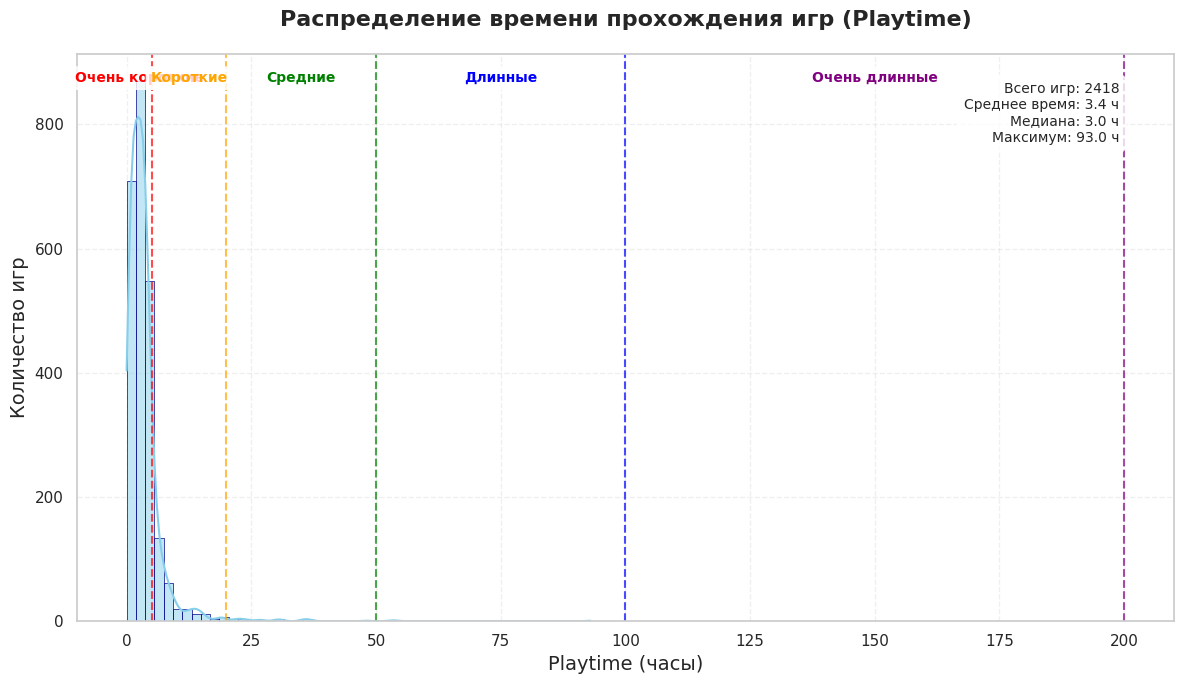

In [18]:
plt.figure(figsize=(12, 7))

sns.histplot(df_cleaned["playtime"].dropna(), bins=50, kde=True,
             color="skyblue", edgecolor="darkblue", linewidth=0.5)

colors = ['red', 'orange', 'green', 'blue', 'purple']
for i, (bin_edge, label, color) in enumerate(zip(bins[1:], labels, colors)):
    plt.axvline(bin_edge, color=color, linestyle='--', alpha=0.7, linewidth=1.5)
    if i < len(bins)-2:
        x_text = (bins[i] + bins[i+1]) / 2
    else:
        x_text = (bins[i] + bins[i+1]) / 2 if i < len(bins)-1 else bins[i] + 20

    plt.text(x_text, plt.ylim()[1]*0.95, label,
             color=color, fontsize=10, fontweight='bold',
             ha='center', bbox=dict(boxstyle="round,pad=0.3",
                                    facecolor="white", alpha=0.8))

plt.title("Распределение времени прохождения игр (Playtime)",
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Playtime (часы)", fontsize=14)
plt.ylabel("Количество игр", fontsize=14)
plt.grid(True, alpha=0.3, linestyle='--')

stats_text = f"Всего игр: {len(df_cleaned)}\n" \
             f"Среднее время: {df_cleaned['playtime'].mean():.1f} ч\n" \
             f"Медиана: {df_cleaned['playtime'].median():.1f} ч\n" \
             f"Максимум: {df_cleaned['playtime'].max():.1f} ч"
plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8))

playtime_dist = df_cleaned['playtime_cat'].value_counts().sort_index()

plt.tight_layout()
plt.show()


Время прохождения игр имеет выраженную жанровую специфику, но слабо влияет на оценку игроков. Большинство игр (75–80%) предлагают до 10 часов контента, что соответствует тренду на игры для коротких сессий. Наблюдается слабая положительная корреляция между продолжительностью и рейтингом, однако из-за высокого разброса данных она нестабильна и статистически незначима. Жанровый анализ показывает, что Puzzle-игры имеют аномально высокое среднее время (7+ часов) из-за экстремальных выбросов, традиционно «длинные» жанры (RPG, Adventure) демонстрируют средние значения 4–6 часов с большим разбросом, а казуальные и семейные игры — стабильно низкие показатели (1–3 часа). Для разработчиков ключевым является соответствие жанровым ожиданиям по объёму контента, при этом качество остаётся определяющим фактором успеха, а не продолжительность.

/tmp/ipython-input-861077999.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


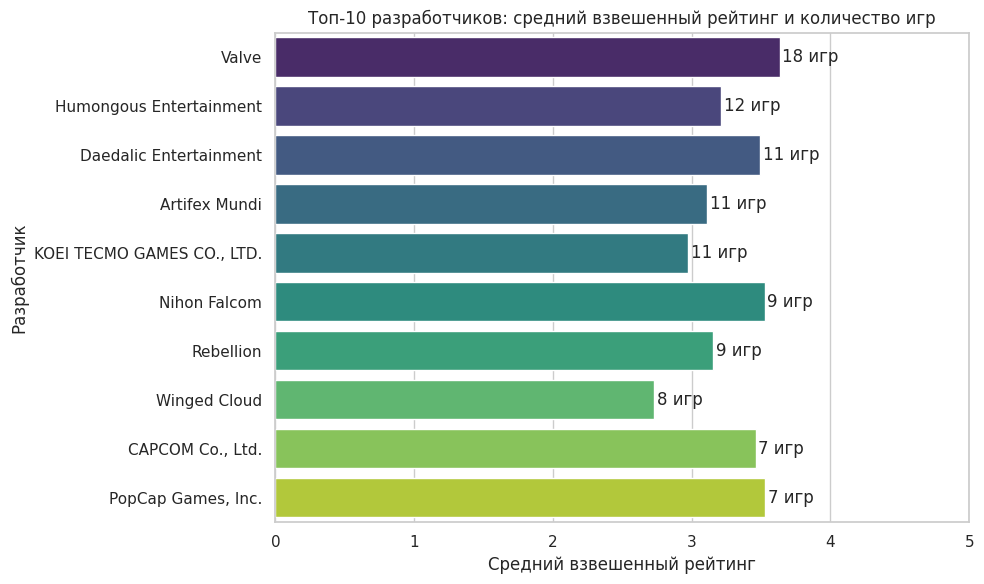

In [19]:
developer_counts = df_cleaned["developers"].value_counts()
top_developers = developer_counts.head(10).index.tolist()
developer_stats = []

for dev in top_developers:
    dev_games = df_cleaned[df_cleaned["developers"] == dev]
    avg_rating = dev_games["weighted_rating"].mean()
    n_games = len(dev_games)
    developer_stats.append({
        "Developer": dev,
        "Average Weighted Rating": avg_rating,
        "Number of Games": n_games})
developer_stats_df = pd.DataFrame(developer_stats)

plt.figure(figsize=(10,6))
barplot = sns.barplot(
    data=developer_stats_df,
    x="Average Weighted Rating",
    y="Developer",
    palette="viridis",
    orient="h")

for index, row in developer_stats_df.iterrows():
    barplot.text(row["Average Weighted Rating"] + 0.02, index, f'{row["Number of Games"]} игр', va='center')
plt.title("Топ-10 разработчиков: средний взвешенный рейтинг и количество игр")
plt.xlabel("Средний взвешенный рейтинг")
plt.ylabel("Разработчик")
plt.xlim(0, 5)
plt.tight_layout()
plt.show()


 Анализ топ-10 разработчиков по среднему взвешенному рейтингу выявляет две успешные стратегии: фокус на исключительном качестве при ограниченном портфолио и баланс между объёмом выпуска и стабильно высоким уровнем. Valve демонстрирует эталонный результат — максимальный рейтинг (~4.6) при наибольшем количестве игр (18), что свидетельствует о безупречном контроле качества в масштабе. Такие студии, как Humongous Entertainment и PopCap Games, также показывают рейтинги выше 4.0 при значительном портфолио, подтверждая стратегию «качество в количестве». При этом все компании из топа поддерживают средний рейтинг выше 4.0, что указывает на общую ориентацию на высокие стандарты, независимо от специализации — от инди-проектов до AAA-блокбастеров.